## Description:
######Model type = LSTM
######Hidden layers = 128*2
######train seq_len = 10
######model id = lstm128-10


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

import io

In [5]:
#mount google drive on colab for saving pytorch model variables
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Data Loading

In [6]:
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
test_data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_valid.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
with io.open(data_path, 'r', encoding = 'utf8') as f:
    text = f.read()
with io.open(test_data_path, 'r', encoding = 'utf8') as f:
    test_text = f.read()

chars = set(text)
tchars = set(test_text)
char2int = {c:i for i,c in enumerate(chars)}
int2char = dict(enumerate(chars))
nptext = np.array([char2int[ch] for ch in text])
npttext = np.array([char2int[ch] for ch in test_text])

N = nptext.shape[0]
tN = npttext.shape[0]
Nc = len(chars)
tNc = len(tchars)
for ele in tchars:
    assert(ele in chars)
print("all elememts in test data is in train data")
print("total train data length = {}, there are {} kinds of character".format(N, Nc))
print("total test data length = {}, there are {} kinds of character".format(tN, tNc))

all elememts in test data is in train data
total train data length = 4351312, there are 67 kinds of character
total test data length = 222025, there are 62 kinds of character


Hyper Params


In [0]:
#data
seq_len = 10
batch_size = 50
#model:
hidden_size = 128
n_layers = 2
#traininng:
n_epoch = 15
lr = 1e-4
dropout = 0.2
print_every = 1  #generate text per 2 epoch
plot_every = 100 #calc accuracy/loss per 100 batch
#model/record saving/loading:
LOAD = False
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
rec_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/rec/"
model_id = "lstm128-10" #save as 
load_model_name = "lstm128-50final_checkpoint_1.639.cp"
rec_name = "rec-"+ model_id + ".pkl"
load_rec_name = "rec-"+ model_id + ".pkl"

Preprocessing Data

In [8]:
from typing import List, Union #python 3.8 requried
num = Union[int, float]
def chunks(arr, chunk_len):
    for i in range(0, len(arr) - chunk_len, chunk_len):
        yield arr[i:i + chunk_len]

def s2tensor(s: str, device: str) -> torch.LongTensor:
    return torch.Tensor([char2int[s[i]] if s[i] in char2int else 0 for i in range(len(s))]).long().to(device)

def tensor2s(t: torch.Tensor) -> str:
    val = t.cpu().detach().numpy()
    ret = "" 
    return ret.join([int2char[val[i]] for i in range(len(val))])

#preprocessing train data:
seqs = list(chunks(nptext, seq_len + 1))
batches = list(chunks(seqs, batch_size))
train_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in batches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(train_data), train_data[0].shape)

#preprocessing test data:
tseqs = list(chunks(npttext, seq_len + 1))
tbatches = list(chunks(tseqs, batch_size))
test_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in tbatches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(test_data), test_data[0].shape)

7911 torch.Size([11, 50])
403 torch.Size([11, 50])


Model

In [0]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, cell_type="rnn", n_layers=2, drop_out=0.2):
        super(CharRNN, self).__init__()
        self.cell_type = cell_type.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.cell_type == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout)
        elif self.cell_type == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden) #print(output.shape)
        output = self.decoder(output) #print(output.shape)
        return output, hidden
    def forwardc(self, input, hidden, device='cpu'): #for characters : torch([long]) to distribution
        input = input.view(1, 1).to(device) #batch = 1, len = 1 #need to be added:to(device)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden)
        output = self.decoder(output)
        output = output.view(self.input_size)
        #print(output)
        return output, hidden

    def init_hidden(self, batch_size=batch_size, device='cpu'):
        if self.cell_type == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device))

Generate Prediction with temparature


In [0]:
def generate(model, device='cpu', seed='Juliet', predict_len=100, tau=0.8): 
    seed_tensor = s2tensor(seed, device) #shape = torch.Size([seqlen])
    #generate hidden 
    h = model.init_hidden(batch_size=1, device=device)
    for x in seed_tensor:
        _, h = model.forwardc(x, h, device)
    #generate seq
    inc = seed_tensor[-1]
    ret = seed
    for i in range(predict_len):
        out, h =  model.forwardc(inc, h, device)
        if tau >= 0.2 :
            tau_distribution = out.detach().data.view(-1).div(tau).exp()
            predi = torch.multinomial(tau_distribution, 1)[0]
        else : #prevent overflow
            _, predi = torch.max(out.detach().data, 0)
        ret += int2char[predi.item()]
        inc = torch.LongTensor([predi])
    return ret

In [0]:
def calc_accuracy(model, data, n_batch=10, device='cpu'):
    #eval accuracy for model on data with n_batch random batches, rach batch itself is continueous
    l = np.random.randint(0, len(data)-n_batch)
    r = l+n_batch
    correct_predictions = 0.0
    total = 0.0
    for batch_tensor in data[l:r]:
        hidden = model.init_hidden(batch_size=batch_tensor.size(1), device=device)
        input_variable = Variable(batch_tensor[:-1]).to(device)
        target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
        # prediction and calculate loss
        output, _ = model(input_variable, hidden)
        output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
        _, predicted = torch.max(output.data, 1)
        total += predicted.size(0)
        correct_predictions += (predicted.long() == target_variable.long()).sum()
    return (correct_predictions/total).item()

Test Functionality

In [12]:
def test_model(cell_type="rnn", device='cpu'):
    print("testing {} model".format(cell_type))
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    model.to(device)
    print("test forward")
    tout, thidden = model(train_data[0].to(device), model.init_hidden(batch_size, device))
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test forwardc")
    tout, thidden = model.forwardc(torch.LongTensor([45]).to(device), model.init_hidden(1, device), device)
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test cal_accuracy")
    print(calc_accuracy(model, test_data, n_batch=10, device=device))
    print("test generate with forwardc")
    print(generate(model, device, tau=0.1), '\n')
test_model("rnn", "cuda")
test_model("lstm", "cuda")

testing rnn model
test forward
torch.Size([11, 50, 67]) torch.Size([2, 50, 128])
test forwardc
torch.Size([67]) torch.Size([2, 1, 128])
test cal_accuracy
0.017799999564886093
test generate with forwardc
Juliet::  TlQYqlw?!JQlMQa]Pw- w  yokBWch]o &V ,yKy,?A,,,,,
M&yBYWlD]qYcyD:]3Pw-PGI-P?WV YWlQ[MNyt:W P!WVpY 

testing lstm model
test forward
torch.Size([11, 50, 67]) torch.Size([2, 50, 128]) torch.Size([2, 50, 128])
test forwardc
torch.Size([67]) torch.Size([2, 1, 128]) torch.Size([2, 1, 128])
test cal_accuracy
0.007799999788403511
test generate with forwardc
Julietaaa[[[[[[PooPPPKoBoPKK


e[PPPPoKos[[[[PPPPPPKKo
oPPKKaaaPKaa[[[[PPPooPo:[[[PPoPPPPKK

PPPPKBPPPKKaa 



Train

Build new model

In [13]:
if not LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type="lstm", n_layers=2)
    record = {
        'loss' : [],
        'trainAC' : [],
        'testAC' : []
    }
    print("new model and record initted")

new model and record initted


Load saved model

In [0]:
if LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type="lstm", n_layers=2)
    model.load_state_dict(torch.load(model_path+load_model_name)['model'])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.load_state_dict(torch.load(model_path+load_model_name)['optimizer'])
    print('Model parameters loaded from disk.')
    import pickle
    with open(rec_path+load_rec_name, "rb") as fo: 
        record = pickle.load(fo)
    print('Records loaded from disk.')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print("model device : ", device)

Use GPU if available

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("model device : ", device)

model device :  cuda:0


In [0]:
import tqdm #set position and leave for colab
import time

def train():
    if not LOAD: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    hidden = model.init_hidden(batch_size, device)
    model.train()
    try:
        #epoch_progress = tqdm.tqdm(range(1, n_epoch + 1),position=0, leave=True)
        best_ep_loss = float('inf')
        for epoch in range(1, n_epoch + 1):
            np.random.shuffle(train_data)
            batches_progress = tqdm.tqdm(train_data, position=0, leave=True)
            ep_loss = 0.0
            ep_train_ac = 0.0
            ep_test_ac = 0.0
            cnt = 0.0
            for batch, batch_tensor in enumerate(batches_progress):
                model.train()
                # reset gradients
                model.zero_grad()
                # data
                input_variable = Variable(batch_tensor[:-1]).to(device)
                target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
                # prediction
                output, _ = model(input_variable, hidden)
                output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
                #loss and backward
                loss = loss_function(output, target_variable)
                loss.backward()
                optimizer.step()
                #record
                if batch%plot_every == 0:
                    _, predicted = torch.max(output.data, 1)
                    total = predicted.size(0)
                    correct_predictions = (predicted.long() == target_variable.long()).sum()
                    train_ac = (correct_predictions*1.0/total).item()
                    test_ac = calc_accuracy(model, test_data, n_batch=1, device=device)
                    loss = loss.item()
                    record['loss'].append(loss), record['trainAC'].append(train_ac), record['testAC'].append(test_ac)
                    ep_loss += loss
                    ep_train_ac += train_ac
                    ep_test_ac += test_ac
                    cnt += 1.0
                    batches_progress.set_postfix(loss='{:.03f}'.format(loss), train_ac='{:.03f}'.format(train_ac), test_ac='{:.03f}'.format(test_ac))

            #epoch_progress.set_postfix(loss='{:.03f}'.format(ep_loss))
            model.eval()
            ep_loss /= cnt
            ep_train_ac /= cnt
            ep_test_ac /= cnt
            best_ep_loss = min(best_ep_loss, loss)
            #generate some ep string
            #time.sleep(0.01)
            tqdm.tqdm.write("\nAt {} epoche, loss = {:.03f}, train ac = {:.03f}, test ac = {:.03f}".format(epoch, ep_loss, ep_train_ac, ep_test_ac))
            seed = 'Juliet'
            tqdm.tqdm.write("RNN write with seed {}".format(seed))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write(generate(model, device, seed, 150))
            tqdm.tqdm.write("\n##############################\n")
            
            #save best model in ep as checkpoint
            if loss == best_ep_loss:
                checkpoint_path = os.path.join(model_path, model_id+'checkpoint_ep_'+str(epoch))+ str('{:.03f}'.format(loss)) + '.cp'
                torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }, checkpoint_path)

    except KeyboardInterrupt:
        pass

    #save
    model.eval()
    final_path = os.path.join(model_path, model_id+'final_checkpoint_')+ str('{:.03f}'.format(loss)) + '.cp' 
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }, final_path)
    import pickle
    with open(rec_path+rec_name, "wb") as fo: #wb
        pickle.dump(record,fo)
        print('Tranning records saved to disk.')

In [17]:
train()

  0%|          | 0/7911 [00:00<?, ?it/s, loss=2.097, test_ac=0.374, train_ac=0.388]


At 1 epoche, loss = 2.359, train ac = 0.340, test ac = 0.342
RNN write with seed Juliet

##############################

Julieter wef sear of as aarss,
If fare at stear in Rone, do to dere?

ILALIA:
To lide,
And Dantone is best be mearthing to reton ere,
Thow hereatie no day s

##############################



  0%|          | 0/7911 [00:00<?, ?it/s, loss=1.852, test_ac=0.376, train_ac=0.444]


At 2 epoche, loss = 2.032, train ac = 0.405, test ac = 0.403
RNN write with seed Juliet

##############################

Julietriates, she due?

SAMENTOMLALIO:
To what be some,
And gone, and sturn you come her more gaster to vate then then; sace;
That thas goal:
But she man it

##############################



  0%|          | 27/7911 [00:00<00:29, 269.08it/s, loss=1.881, test_ac=0.424, train_ac=0.478]


At 3 epoche, loss = 1.934, train ac = 0.427, test ac = 0.414
RNN write with seed Juliet

##############################

Julieter: but fancake my will I do not a see,
And wiffeg to martos the fallanty on the shad the lay go tury to, this not That his become,
Be, with he matter

##############################



  0%|          | 0/7911 [00:00<?, ?it/s, loss=1.821, test_ac=0.402, train_ac=0.444]


At 4 epoche, loss = 1.887, train ac = 0.440, test ac = 0.432
RNN write with seed Juliet

##############################

Julieter lotteds, and be do I what daren.

DIMON:
Of and the denafier love, sword from it hear stall
Biath his is of chample.

SING LEAR:
No then; that not 

##############################



  0%|          | 28/7911 [00:00<00:28, 278.55it/s, loss=1.904, test_ac=0.418, train_ac=0.452]


At 5 epoche, loss = 1.851, train ac = 0.449, test ac = 0.437
RNN write with seed Juliet

##############################

Juliet;
Le more of from the lord, lord?

IKING EPHENSIO:
I am this I am for the so this
flate of king what, good fears: and I hope with my may, good hath th

##############################



  0%|          | 0/7911 [00:00<?, ?it/s, loss=1.977, test_ac=0.448, train_ac=0.404]


At 6 epoche, loss = 1.828, train ac = 0.455, test ac = 0.443
RNN write with seed Juliet

##############################

Julieter.

BENEDINIUS:
No, is not needs of a thee to he me, I would eyes and his life condossand and being cart the reverent of sour of thy horse the know m

##############################



  0%|          | 26/7911 [00:00<00:30, 255.58it/s, loss=1.838, test_ac=0.442, train_ac=0.444]


At 7 epoche, loss = 1.813, train ac = 0.461, test ac = 0.442
RNN write with seed Juliet

##############################

Julietion much clearing you know your hath pock and God full poir of the malest him: and what may for hath no, and loved readon;
He me't in not I did.
And e

##############################



  0%|          | 29/7911 [00:00<00:27, 286.97it/s, loss=1.721, test_ac=0.460, train_ac=0.434]


At 8 epoche, loss = 1.786, train ac = 0.462, test ac = 0.450
RNN write with seed Juliet

##############################

Juliety?

OPHIN:
Will past countrange in, side desire in the long and love the alestly consatient of medo, and Laery
Nor be is a king the each that you lady

##############################



  0%|          | 29/7911 [00:00<00:27, 284.78it/s, loss=1.819, test_ac=0.470, train_ac=0.460]


At 9 epoche, loss = 1.796, train ac = 0.461, test ac = 0.447
RNN write with seed Juliet

##############################

Juliety.

DOMIIO REMIO:
I came it can whose means love but in the daid, bure thright shalls not of our fool.

GRLADFORD:
I will good pournelt.

YORK:
They t

##############################



  0%|          | 28/7911 [00:00<00:28, 272.84it/s, loss=1.566, test_ac=0.430, train_ac=0.516]


At 10 epoche, loss = 1.774, train ac = 0.469, test ac = 0.459
RNN write with seed Juliet

##############################

Julieter, my honour in my two you, for, you gone,
Madam on the whisses with the shaped? what tell this daughter, and thither the note that he is not peeding

##############################



  0%|          | 0/7911 [00:00<?, ?it/s, loss=1.705, test_ac=0.442, train_ac=0.496]


At 11 epoche, loss = 1.778, train ac = 0.464, test ac = 0.460
RNN write with seed Juliet

##############################

Julieter that for draw earth, go the best to his all die I am our bently know what, wherein methis part, you now as down:
But hath a company in the short,
W

##############################



  0%|          | 30/7911 [00:00<00:26, 295.55it/s, loss=1.797, test_ac=0.468, train_ac=0.470]


At 12 epoche, loss = 1.750, train ac = 0.471, test ac = 0.461
RNN write with seed Juliet

##############################

Juliet yet not tell Well, if thee your wing in the quiet instround.

POSTHURES:
Bay do am degeler to this such a shall be her is your drows and looks, and l

##############################



  0%|          | 26/7911 [00:00<00:30, 257.73it/s, loss=1.764, test_ac=0.448, train_ac=0.454]


At 13 epoche, loss = 1.737, train ac = 0.479, test ac = 0.457
RNN write with seed Juliet

##############################

Julieter knight,
That shall be all their Saffort: and have here the atience, but man you there not, I do you have a shame
With all the ated of fathers,
Say 

##############################



  0%|          | 28/7911 [00:00<00:28, 272.45it/s, loss=1.658, test_ac=0.458, train_ac=0.514]


At 14 epoche, loss = 1.754, train ac = 0.473, test ac = 0.465
RNN write with seed Juliet

##############################

Julieter's meant not lest, whom my lord
As you hundry and But, these eyes honestion,
And be hence and the Lord Gentlemen fortune is forget in the bultion by

##############################



100%|██████████| 7911/7911 [00:27<00:00, 283.21it/s, loss=1.764, test_ac=0.450, train_ac=0.474]



At 15 epoche, loss = 1.728, train ac = 0.483, test ac = 0.459
RNN write with seed Juliet

##############################

Julieter suck and thou be here.

PORTIO:

OCTAPIO:
And further to bent.

BIONCE:
Sir, sir, but against be of rather should he will dreps not offence the res

##############################

Tranning records saved to disk.


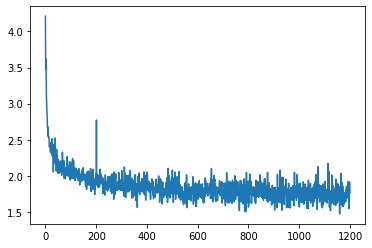

In [18]:
plt.figure()
plt.plot(record['loss'])
plt.show()

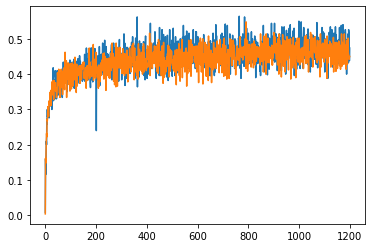

In [19]:
plt.figure()
plt.plot(record['trainAC'])
plt.plot(record['testAC'])
plt.show()

In [20]:
print(generate(model, device)) #default tau = 0.8
calc_accuracy(model, test_data, n_batch=len(test_data)-1, device=device)

Julieter thought to me he should death and swear for himself make a mother thee,
And be who estand the sus


0.4732089340686798

In [21]:
print(generate(model, device, seed='juliet', tau=0.1), '\n') #deterministic
print(generate(model, device, seed='juliet', tau=2), '\n') #radom

julieter the strange the strange the strange the strange the strange the strange the strange the strange t 

julieted;' if devit: jutkid.

FiLiilen Gry, budup
injeoray
Steokstlard
me! noit name: xmake, toid earcumon 



In [24]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') #middle, produce longer

i willy.

HERO:
These haped Jature end best,
To can should be, what father too
before's that dissend were eye have to dargles!
Reters thou do the soul are man;
The compon my honour with my stand own hope,
To god me to the yourself,
What do go to the Passion master, let a thear again; The set under her to them.

BRUTUS:
Away, sir, that's king, but my lord, my hear the treathes?

PROSPERICK:
Like done as place of my truar and to do the contemple him by him he will see an under worthy choul of me so, I h 



In [26]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') #middle, produce longer

i willow the mind the joys and night the lie as return to
present to dear wrips to;
For I knows great in own an, let speak revenge and secius here in the heart was thing:
And I have
fair with bearly's sight: too reed, this guest thou strapfly saw on the commons' thee?

First Cheer.

GLOUCESTER:
Marry, if come,
That thy places it have merry,
And not thy love and isseasts, by the rest that talk, if I speak with a wars son of his stink he will not do
she doth some the virtue, Duke of craces me as wear an 



In [27]:
print(model)

CharRNN(
  (encoder): Embedding(67, 128)
  (rnn): LSTM(128, 128, num_layers=2, dropout=0.2)
  (decoder): Linear(in_features=128, out_features=67, bias=True)
)
